<a href="https://colab.research.google.com/github/sanghee0627/-/blob/main/epoch30%EC%B5%9C%EC%A2%85%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

import os
import time
import copy
import glob
import cv2
import shutil

import torchvision.models as models

import torch.optim as optim


from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/fox.zip 파일 선택

Saving fox.zip to fox.zip


In [2]:
!unzip fox.zip -d fox/

Archive:  fox.zip
   creating: fox/fox/
  inflating: fox/fox/.DS_Store       
  inflating: fox/__MACOSX/fox/._.DS_Store  
   creating: fox/fox/test/
   creating: fox/fox/train/
   creating: fox/fox/test/붉은여우/
  inflating: fox/fox/test/.DS_Store  
  inflating: fox/__MACOSX/fox/test/._.DS_Store  
   creating: fox/fox/test/북극여우/
   creating: fox/fox/train/붉은여우/
  inflating: fox/fox/train/.DS_Store  
  inflating: fox/__MACOSX/fox/train/._.DS_Store  
   creating: fox/fox/train/북극여우/
  inflating: fox/fox/test/붉은여우/1080.jpeg  
  inflating: fox/__MACOSX/fox/test/붉은여우/._1080.jpeg  
  inflating: fox/fox/test/붉은여우/1096.jpeg  
  inflating: fox/__MACOSX/fox/test/붉은여우/._1096.jpeg  
  inflating: fox/fox/test/붉은여우/1079.jpeg  
  inflating: fox/__MACOSX/fox/test/붉은여우/._1079.jpeg  
  inflating: fox/fox/test/붉은여우/071859b6aefc21736c70894f9cf5bdf3.jpeg  
  inflating: fox/__MACOSX/fox/test/붉은여우/._071859b6aefc21736c70894f9cf5bdf3.jpeg  
 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data_path = 'fox/fox/train'

transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), #이미지 뒤집기
    transforms.RandomRotation(10),  # 10범위로 랜덤회전(이미지 회전)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #적절한 평균 및 표준 편차를 사용한 정규화
])

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

119


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
test_path = 'fox/fox/test/'

transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), #이미지 뒤집기
    transforms.RandomRotation(10),  # 10범위로 랜덤회전(이미지 회전)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #적절한 평균 및 표준 편차를 사용한 정규화
])

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,#배치조정
    num_workers=8,
    shuffle=True
)

print(len(test_dataset))

69


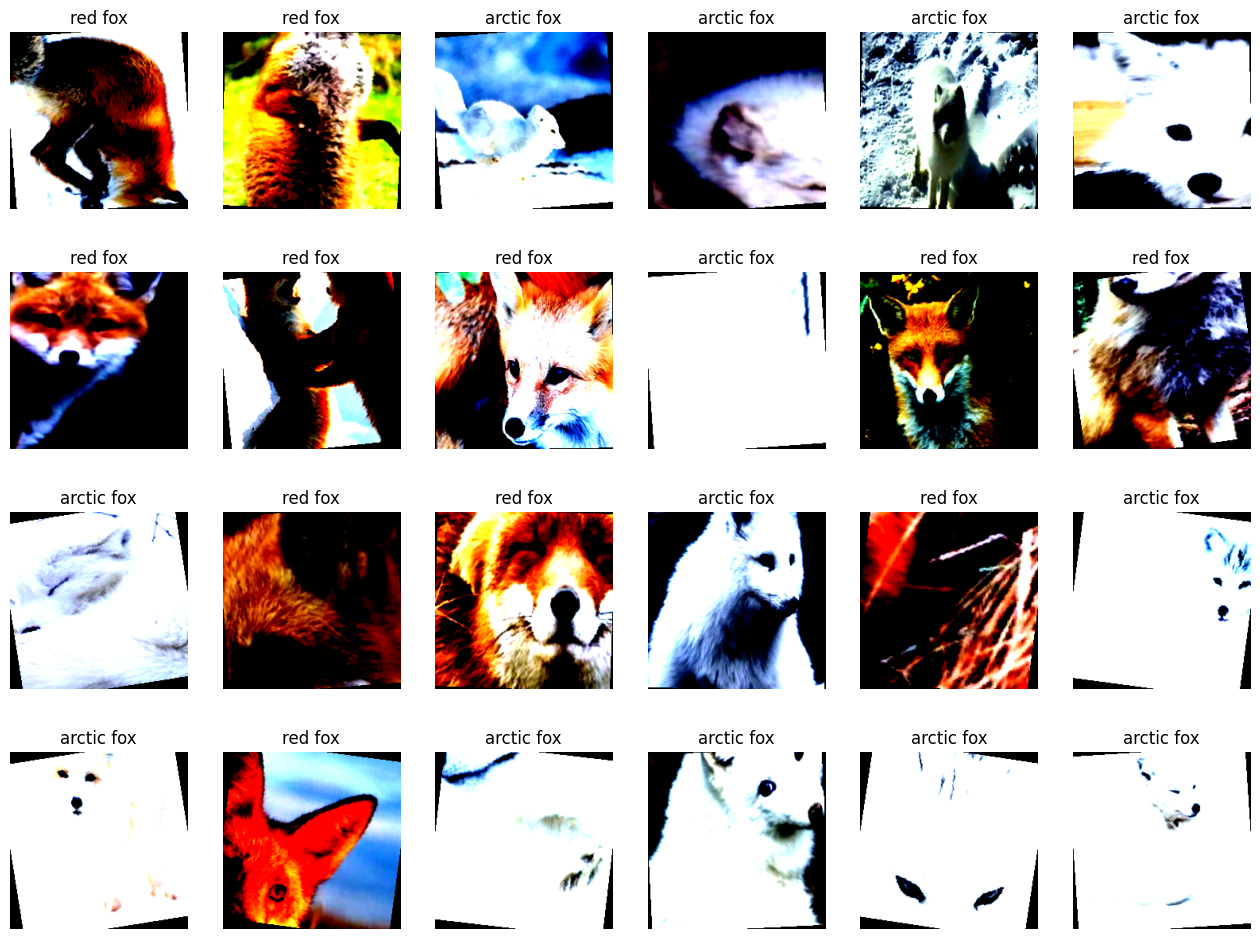

In [6]:
# check dataset
samples, labels = next(iter(train_loader))
classes = {0:'arctic fox', 1:'red fox'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [16]:
resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(device)
resnet18.fc = nn.Linear(512, 2)

learning_rate = 0.001;#학습률조정   
optimizer = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) 

dataloaders = {
    'train': train_loader,
    'eval' : test_loader
}

In [17]:
# 훈련 및 검증 손실 값을 저장할 리스트
train_losses = []
eval_losses = []

# 훈련 및 검증 정확도 값을 저장할 리스트
train_accuracies = []
eval_accuracies = []

# 훈련 반복 횟수를 저장할 변수
total_epochs = 30

# 모델 훈련 루프
for epoch in range(total_epochs):
    print(f"Epoch {epoch+1}/{total_epochs}")
    print("-" * 10)
    
    # 훈련 모드 설정
    resnet18.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 훈련 데이터 배치별로 학습
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(dataloaders['train'])
    train_acc = correct / total
    
    # 검증 모드 설정
    resnet18.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 검증 데이터 배치별로 예측 성능 확인
    with torch.no_grad():
        for inputs, labels in dataloaders['eval']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    eval_loss = running_loss / len(dataloaders['eval'])
    eval_acc = correct / total
    
    # 훈련 및 검증 손실 값 저장
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)
    
    # 훈련 및 검증 정확도 값 저장
    train_accuracies.append(train_acc)
    eval_accuracies.append(eval_acc)
    
    # 훈련 결과 출력
    print(f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}")
    print(f"Eval Loss: {eval_loss:.4f} Eval Acc: {eval_acc:.4f}")
    print()
    
    # 학습률 스케줄러 업데이트
    scheduler.step(train_loss)


Epoch 1/30
----------
Train Loss: 0.3081 Train Acc: 0.8403
Eval Loss: 2.3539 Eval Acc: 0.5797

Epoch 2/30
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Loss: 0.2836 Train Acc: 0.9496
Eval Loss: 2.2480 Eval Acc: 0.6522

Epoch 3/30
----------
Train Loss: 0.0861 Train Acc: 0.9748
Eval Loss: 0.3513 Eval Acc: 0.9130

Epoch 4/30
----------
Train Loss: 0.1179 Train Acc: 0.9412
Eval Loss: 0.8433 Eval Acc: 0.9420

Epoch 5/30
----------
Train Loss: 0.1455 Train Acc: 0.9412
Eval Loss: 4.8681 Eval Acc: 0.8406

Epoch 6/30
----------
Train Loss: 0.2032 Train Acc: 0.8992
Eval Loss: 0.4401 Eval Acc: 0.9565

Epoch 7/30
----------
Train Loss: 0.1528 Train Acc: 0.9412
Eval Loss: 1.8011 Eval Acc: 0.7681

Epoch 8/30
----------
Train Loss: 0.0888 Train Acc: 0.9412
Eval Loss: 0.1450 Eval Acc: 0.9420

Epoch 9/30
----------
Train Loss: 0.0210 Train Acc: 1.0000
Eval Loss: 0.5632 Eval Acc: 0.9565

Epoch 10/30
----------
Train Loss: 0.0549 Train Acc: 0.9748
Eval Loss: 0.2625 Eval Acc: 0.9130

Epoch 11/30
----------
Train Loss: 0.0371 Train Acc: 0.9832
Eval Loss: 0.2245 Eval Acc: 0.9420

Epoch 12/30
----------
Train Loss: 0.0160 Train Acc: 1.0000
Eval Loss:

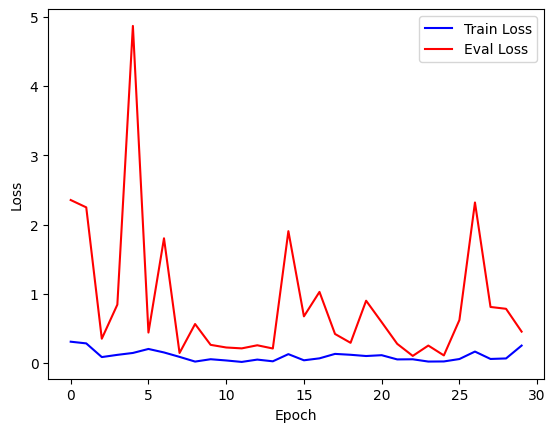

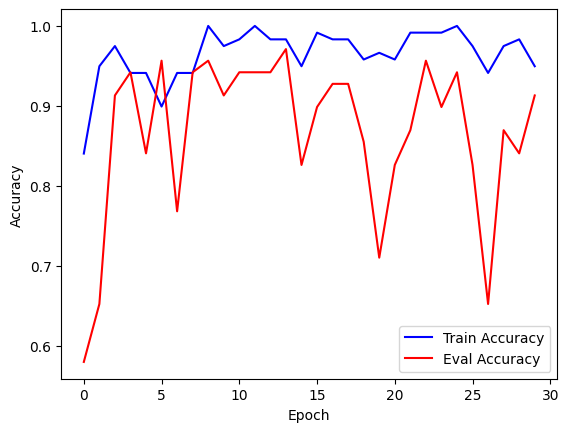

In [18]:
# 테스트 그래프 그리기
plt.plot(train_losses, label='Train Loss', color = "blue")
plt.plot(eval_losses, label='Eval Loss', color = "red")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train Accuracy', color = "blue")
plt.plot(eval_accuracies, label='Eval Accuracy', color = "red")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

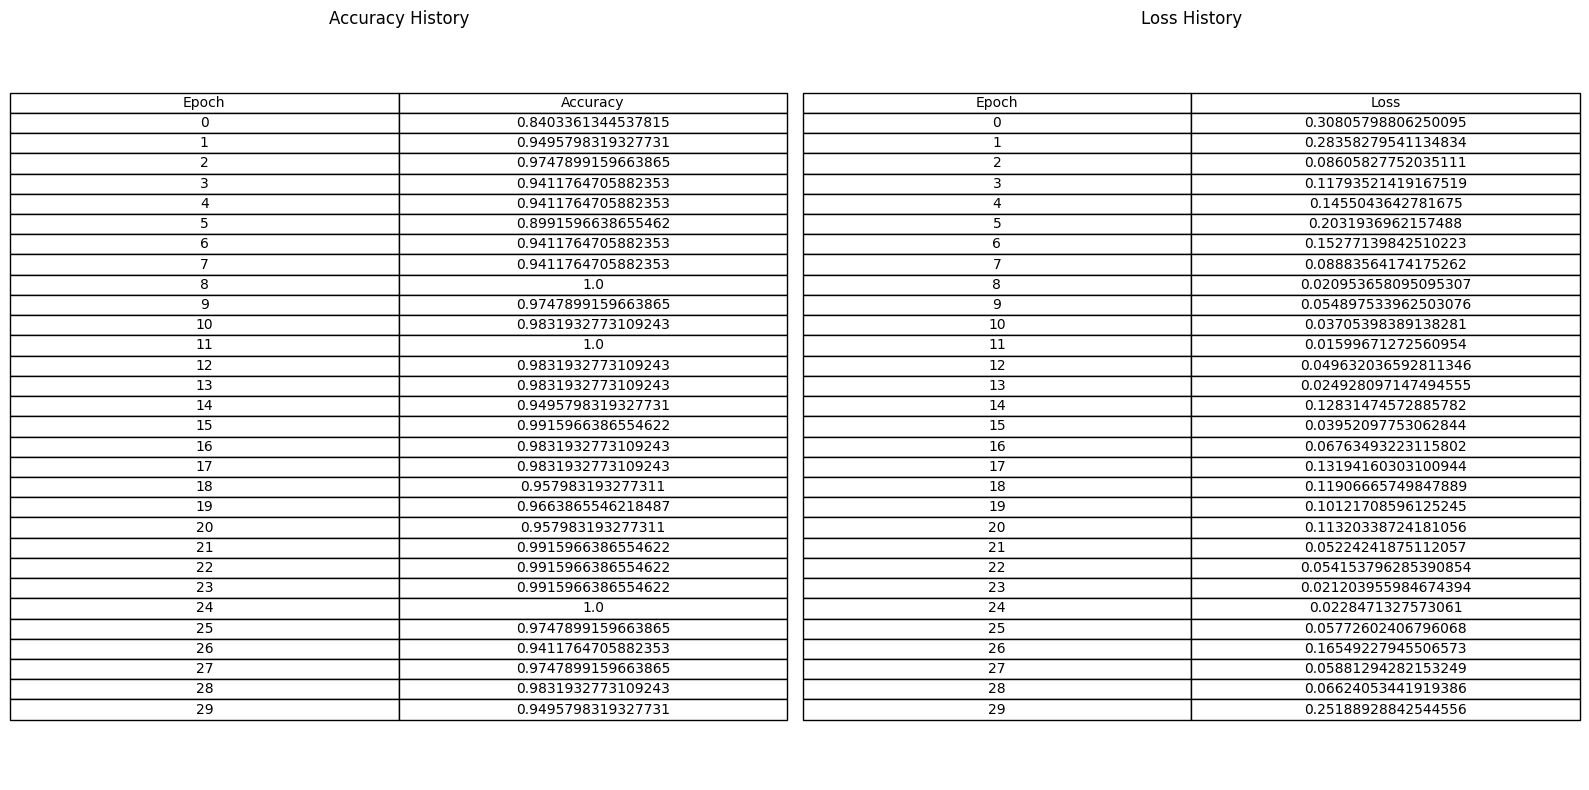

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 정확도 테이블
ax_acc = axes[0]
ax_acc.axis('off')
table_data_acc = [['Epoch', 'Accuracy']] + [[i, acc] for i, acc in enumerate(train_accuracies)]
ax_acc.table(cellText=table_data_acc, loc='center', cellLoc='center')
ax_acc.set_title("Accuracy History")

# 오차 테이블
ax_loss = axes[1]
ax_loss.axis('off')
table_data_loss = [['Epoch', 'Loss']] + [[i, loss] for i, loss in enumerate(train_losses)]
ax_loss.table(cellText=table_data_loss, loc='center', cellLoc='center')
ax_loss.set_title("Loss History")

plt.tight_layout()
plt.show()

Exception ignored in: <function _ConnectionBase.__del__ at 0x7fd76de7f490>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


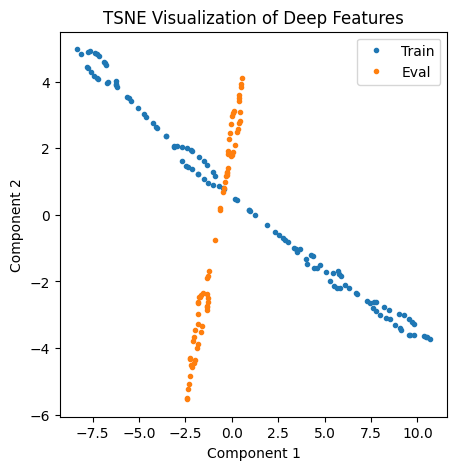

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

actual_train = []
deep_features_train = []
actual_test = []
deep_features_test = []

resnet18.train()

with torch.no_grad():
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = resnet18(images)
        deep_features_train.append(features.cpu().numpy())
        actual_train.append(labels.cpu().numpy())

    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = resnet18(images)
        deep_features_test.append(features.cpu().numpy())
        actual_test.append(labels.cpu().numpy())

actual_train = np.concatenate(actual_train)
deep_features_train = np.concatenate(deep_features_train)
actual_test = np.concatenate(actual_test)
deep_features_test = np.concatenate(deep_features_test)

tsne = TSNE(n_components=2, random_state=0)
cluster_train = tsne.fit_transform(deep_features_train)
cluster_test = tsne.fit_transform(deep_features_test)

plt.figure(figsize=(5, 5))
name = ['arctic fox', 'red fox']
plt.plot(cluster_train[:, 0], cluster_train[:, 1], '.', label='Train')
plt.plot(cluster_test[:, 0], cluster_test[:, 1], '.', label='Eval')
plt.legend()
plt.title("TSNE Visualization of Deep Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()